<a href="https://colab.research.google.com/github/Wahiba275/KDD_Cup_Dataset_-with_Missing_Values-/blob/main/KDD_Cup_Dataset_(with_Missing_Values).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 30 15:23:48 2024

@author: F.Ayoub
"""

from datetime import datetime
from distutils.util import strtobool

import pandas as pd
import numpy as np


# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


# Example of usage
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("kdd_cup_2018_dataset_with_missing_values.tsf") # Inser the path to your data

print(loaded_data)
print(frequency)
print(forecast_horizon)
print(contain_missing_values)
print(contain_equal_length)

# Extract only the "Series_value" to an Array of float
data = loaded_data["series_value"]

data = pd.DataFrame.from_records(data).to_numpy()

data = np.reshape(data, (data.shape[1], data.shape[0]))





    series_name     city          station air_quality_measurement  \
0            T1  Beijing  aotizhongxin_aq                   PM2.5   
1            T2  Beijing  aotizhongxin_aq                    PM10   
2            T3  Beijing  aotizhongxin_aq                     NO2   
3            T4  Beijing  aotizhongxin_aq                      CO   
4            T5  Beijing  aotizhongxin_aq                      O3   
..          ...      ...              ...                     ...   
265        T266   London              BX9                   PM2.5   
266        T267   London              KC1                   PM2.5   
267        T268   London              KC1                    PM10   
268        T269   London              KC1                     NO2   
269        T270   London              CT2                   PM2.5   

        start_timestamp                                       series_value  
0   2017-01-01 14:00:00  [453.0, 417.0, 395.0, 420.0, 453.0, 429.0, 211...  
1   2017-01-01 14

In [2]:
!pip install  -q tensorflow

In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd

# Extract only the "series_value" to an Array of float
data = loaded_data["series_value"]

In [4]:
print(data)

0      [453.0, 417.0, 395.0, 420.0, 453.0, 429.0, 211...
1      [467.0, 443.0, 467.0, 484.0, 520.0, NaN, NaN, ...
2      [156.0, 143.0, 141.0, 139.0, 157.0, 141.0, 110...
3      [7.2, 6.8, 6.9, 7.4, 7.6, 6.5, 3.3, 2.2, 1.3, ...
4      [3.0, 2.0, 3.0, 3.0, 4.0, 3.0, NaN, 4.0, 26.0,...
                             ...                        
265    [23.3, 17.5, 16.6, 18.6, 20.4, 20.5, 21.2, 17....
266    [31.7, 29.9, 21.8, 19.1, 23.7, 25.7, 24.4, 20....
267    [23.2, 23.1, 13.9, 12.8, 13.8, 14.9, 15.1, 13....
268    [21.3, 25.9, 22.6, 23.4, 22.6, 24.9, 27.9, 30....
269    [8.0, 10.0, 8.0, 9.0, 10.0, 12.0, 14.0, 17.0, ...
Name: series_value, Length: 270, dtype: object


In [5]:
# Convert all values in the "series_value" column to float
data_filled = data.apply(lambda series: pd.to_numeric(series, errors='coerce'))

# Fill missing values in each series with the mean of the series
data_filled = data_filled.apply(lambda series: np.where(np.isnan(series), np.nanmean(series), series))


In [6]:
data_filled

0      [453.0, 417.0, 395.0, 420.0, 453.0, 429.0, 211...
1      [467.0, 443.0, 467.0, 484.0, 520.0, 84.4725413...
2      [156.0, 143.0, 141.0, 139.0, 157.0, 141.0, 110...
3      [7.2, 6.8, 6.9, 7.4, 7.6, 6.5, 3.3, 2.2, 1.3, ...
4      [3.0, 2.0, 3.0, 3.0, 4.0, 3.0, 57.021712286478...
                             ...                        
265    [23.3, 17.5, 16.6, 18.6, 20.4, 20.5, 21.2, 17....
266    [31.7, 29.9, 21.8, 19.1, 23.7, 25.7, 24.4, 20....
267    [23.2, 23.1, 13.9, 12.8, 13.8, 14.9, 15.1, 13....
268    [21.3, 25.9, 22.6, 23.4, 22.6, 24.9, 27.9, 30....
269    [8.0, 10.0, 8.0, 9.0, 10.0, 12.0, 14.0, 17.0, ...
Name: series_value, Length: 270, dtype: object

In [7]:
loaded_data['series_value'] = data_filled

In [8]:
loaded_data.head(5)

,series_name,city,station,air_quality_measurement,start_timestamp,series_value
0,T1,Beijing,aotizhongxin_aq,PM2.5,2017-01-01 14:00:00,"[453.0, 417.0, 395.0, 420.0, 453.0, 429.0, 211..."
1,T2,Beijing,aotizhongxin_aq,PM10,2017-01-01 14:00:00,"[467.0, 443.0, 467.0, 484.0, 520.0, 84.4725413..."
2,T3,Beijing,aotizhongxin_aq,NO2,2017-01-01 14:00:00,"[156.0, 143.0, 141.0, 139.0, 157.0, 141.0, 110..."
3,T4,Beijing,aotizhongxin_aq,CO,2017-01-01 14:00:00,"[7.2, 6.8, 6.9, 7.4, 7.6, 6.5, 3.3, 2.2, 1.3, ..."
4,T5,Beijing,aotizhongxin_aq,O3,2017-01-01 14:00:00,"[3.0, 2.0, 3.0, 3.0, 4.0, 3.0, 57.021712286478..."


In [9]:
check_for_nan = loaded_data.isnull().values.any()
print(check_for_nan)

False


<ipython-input-10-56d1d6168856>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in data_filled.iteritems():
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


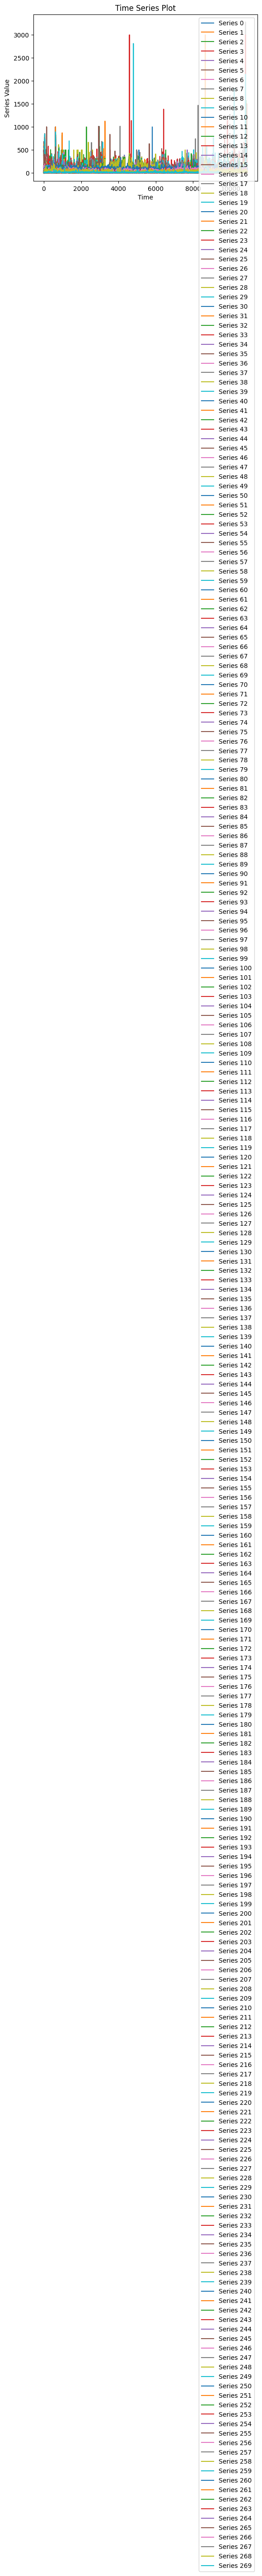

In [10]:
# Visualize multiple time series contained in a Pandas DataFrame named 'data_filled
import matplotlib.pyplot as plt
for column, series in data_filled.iteritems():
    plt.plot(series, label=f'Series {column}')

plt.xlabel('Time')
plt.ylabel('Series Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()


In [11]:
# function allows to easily generate time series plots for a specific city from a DataFrame
def plot_time_series(df, city, num_values=1000, xlabel='Time', ylabel='Series Value', dpi=100):
    plt.figure(figsize=(15, 4), dpi=dpi)

    city_data = df[df['city'] == city]

    for index, row in city_data.iterrows():
        series_values = row['series_value'][:num_values]  # Take only first 1000 values
        plt.plot(series_values, label=f'Series {index}')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'Time Series Plot for {city} (First {num_values} Values)')
    plt.legend()
    plt.show()


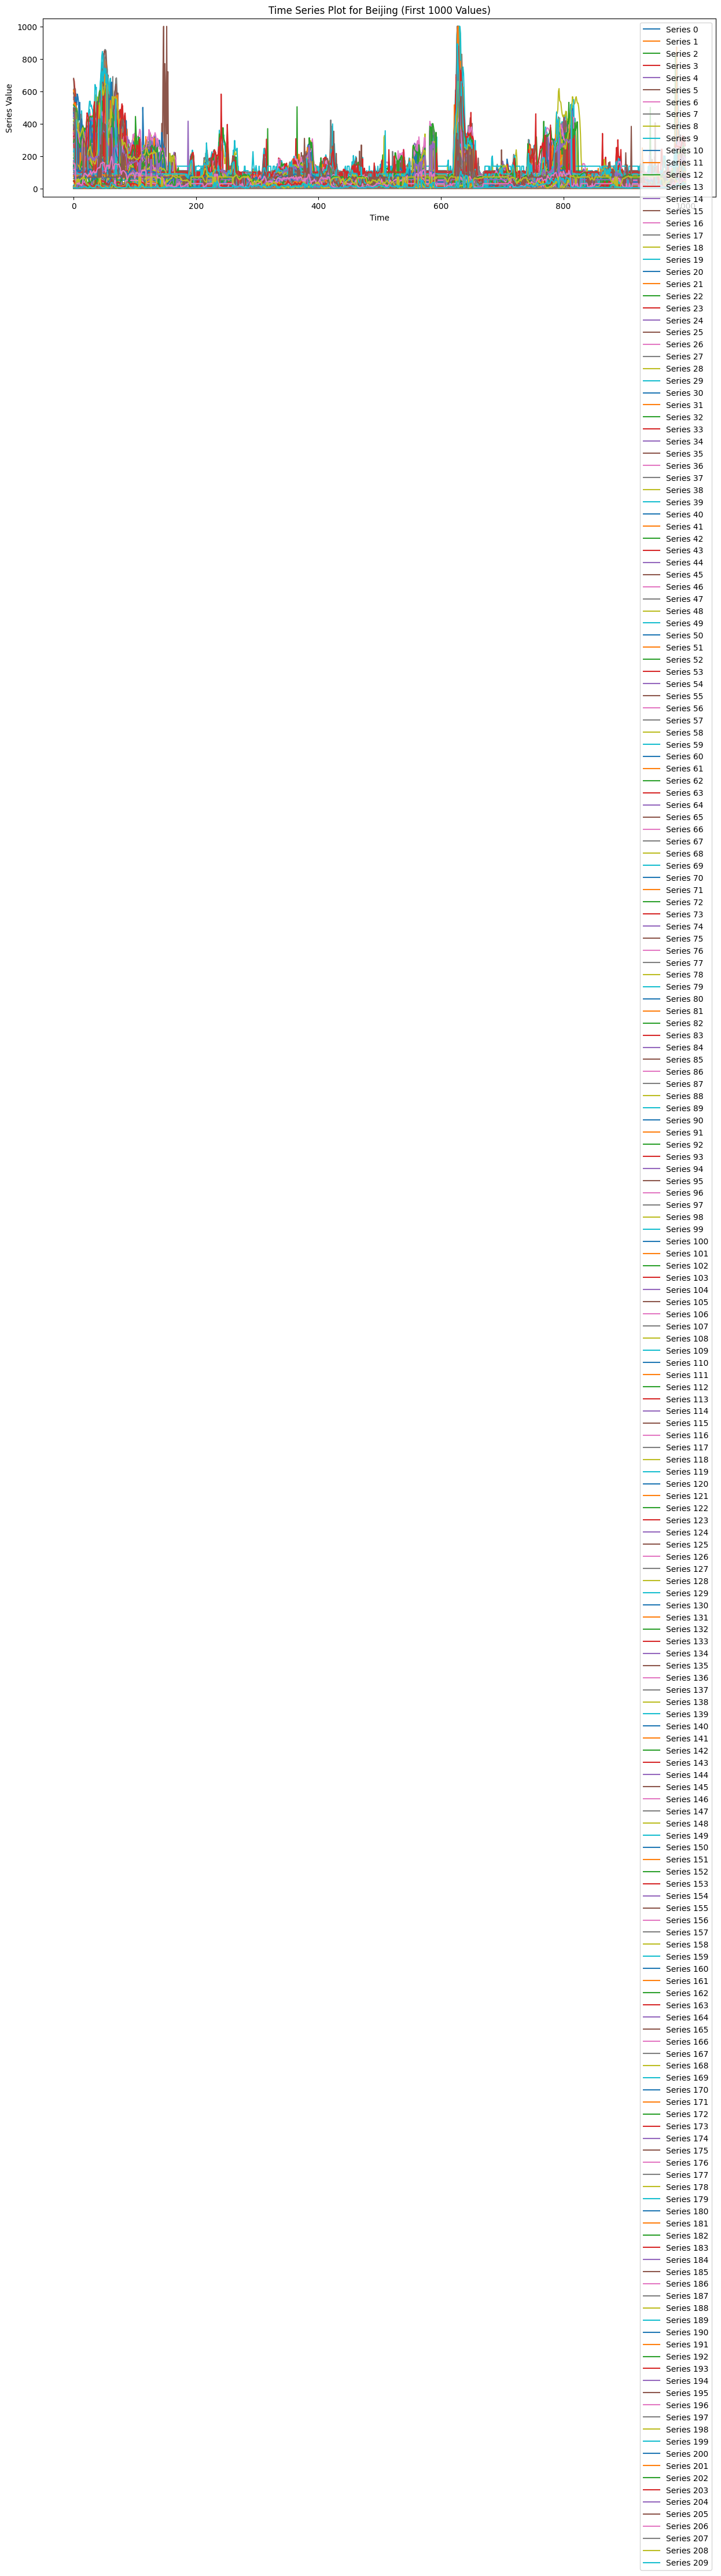

In [14]:
plot_time_series(loaded_data, city='Beijing', num_values=1000)

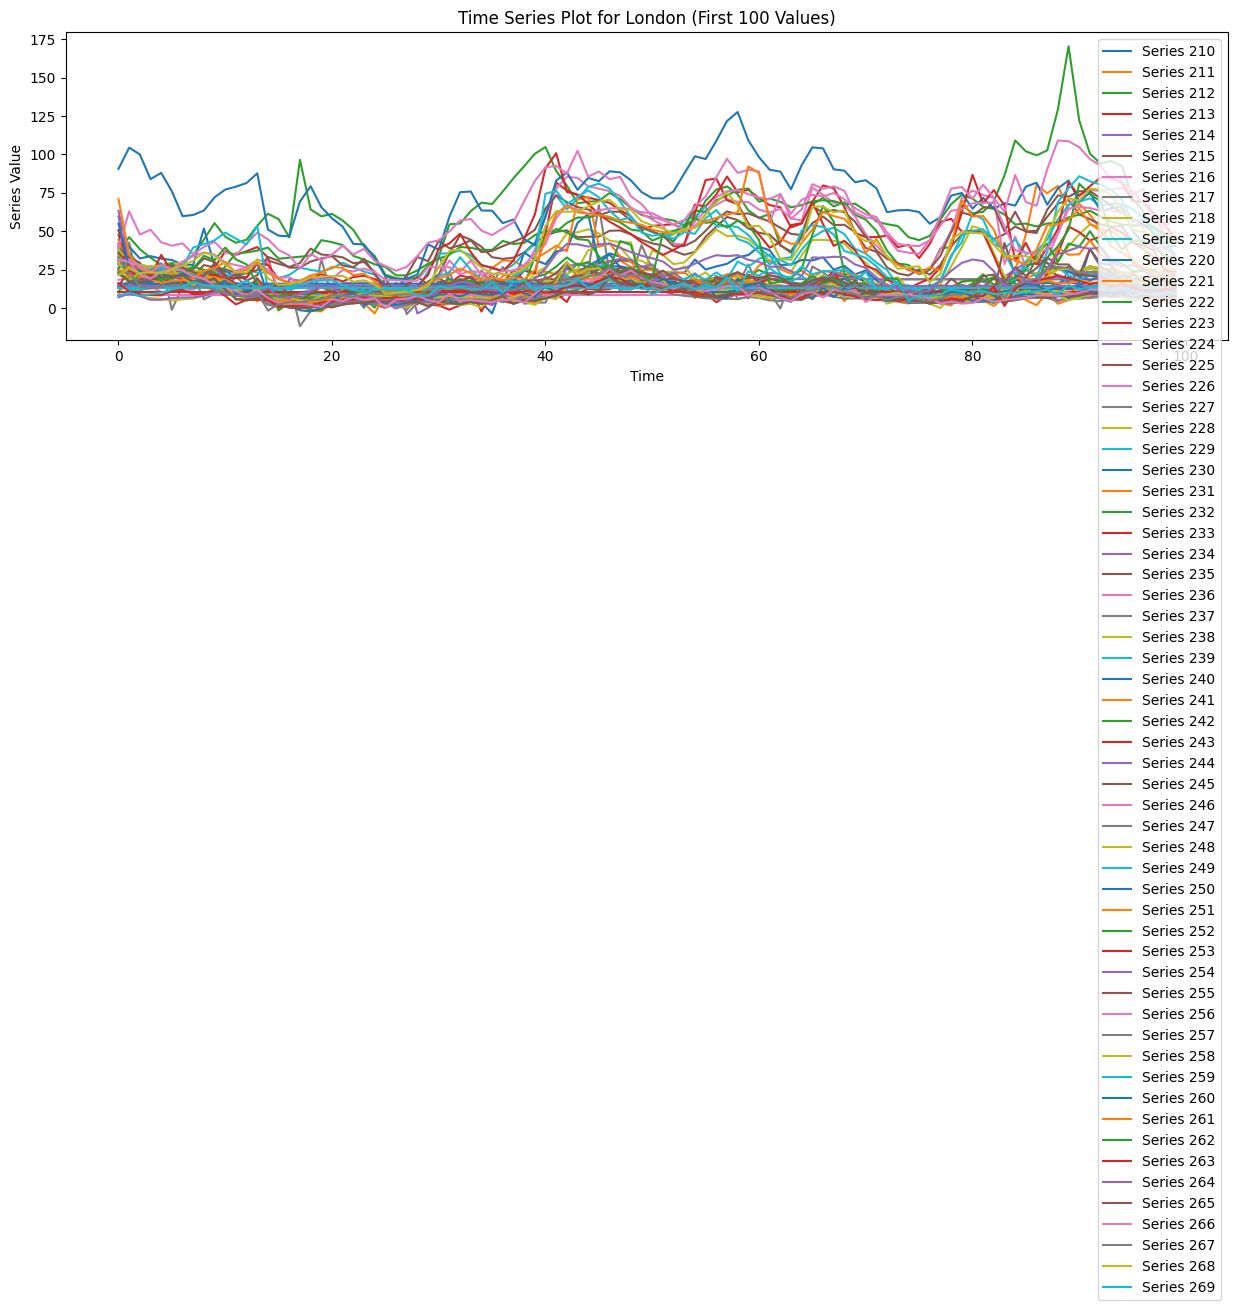

In [15]:
plot_time_series(loaded_data, city='London', num_values=100)

In [16]:
#The code checks the stationarity of a time series using the Augmented Dickey-Fuller test from the statsmodels library
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    if result[1] <= 0.05:
        print("Reject the null hypothesis. The series is likely stationary.")
    else:
        print("Fail to reject the null hypothesis. The series is likely non-stationary.")

beijing_series = loaded_data[loaded_data['city'] == 'Beijing']['series_value'][0]
check_stationarity(beijing_series)


ADF Statistic: -11.0215013779412
p-value: 5.971711853820511e-20
Critical Values: {'1%': -3.430952398842388, '5%': -2.8618062267712765, '10%': -2.5669117073773493}
Reject the null hypothesis. The series is likely stationary.


based on the ADF test, it is concluded that the series is likely stationary.

In [17]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

def decompose_time_series(series_values, city, period=24, plot=True):
    # Create a STL decomposition object
    stl = STL(series_values, seasonal=13, period=period)
    result = stl.fit()

    # Extract the components
    seasonal = result.seasonal
    trend = result.trend
    residual = result.resid

    # Plot the components
    if plot:
        plt.figure(figsize=(15, 10))
        plt.subplot(4, 1, 1)
        plt.plot(series_values, label='Original Series')
        plt.title(f'Time Series Plot for {city}')
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(trend, label='Trend' ,color='red')
        plt.title('Trend Component')
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.plot(seasonal, label='Seasonal',color='green')
        plt.title('Seasonal Component')
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(residual, label='Residual',color='orange')
        plt.title('Residual Component')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return seasonal, trend, residual

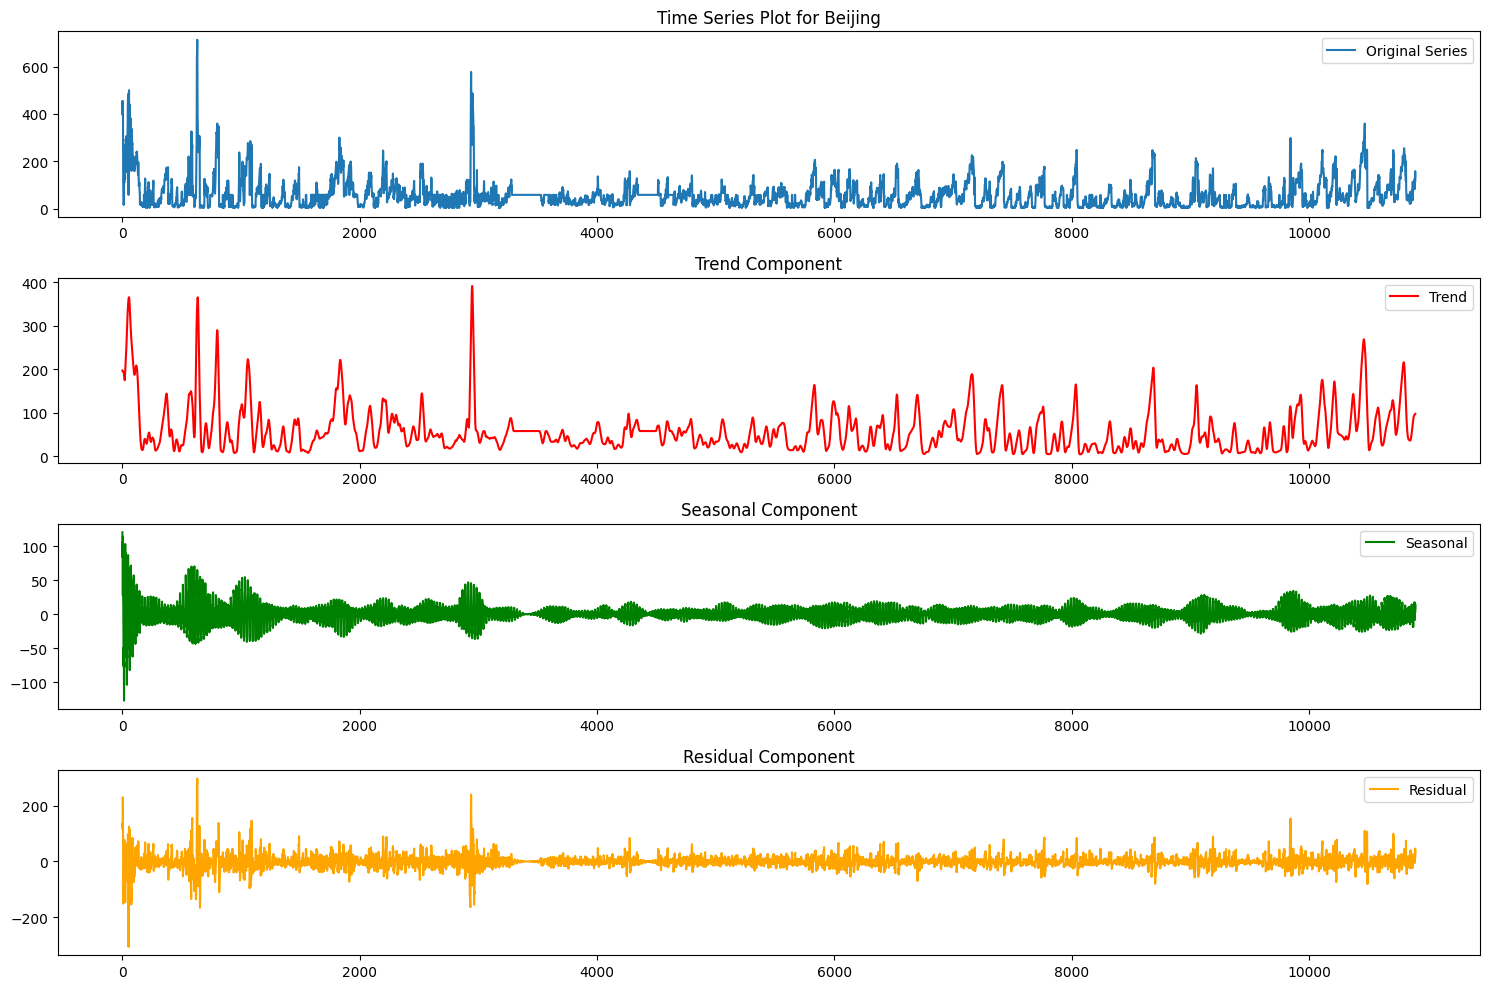

In [18]:
import numpy as np

# Example of using
beijing_series = loaded_data[loaded_data['city'] == 'Beijing']['series_value'].values

# Select a particular sequence (for example, the first)
beijing_series_numpy = np.asarray(beijing_series[0])

# Apply STL decomposition
seasonal, trend, residual = decompose_time_series(beijing_series_numpy, city='Beijing', period=24)


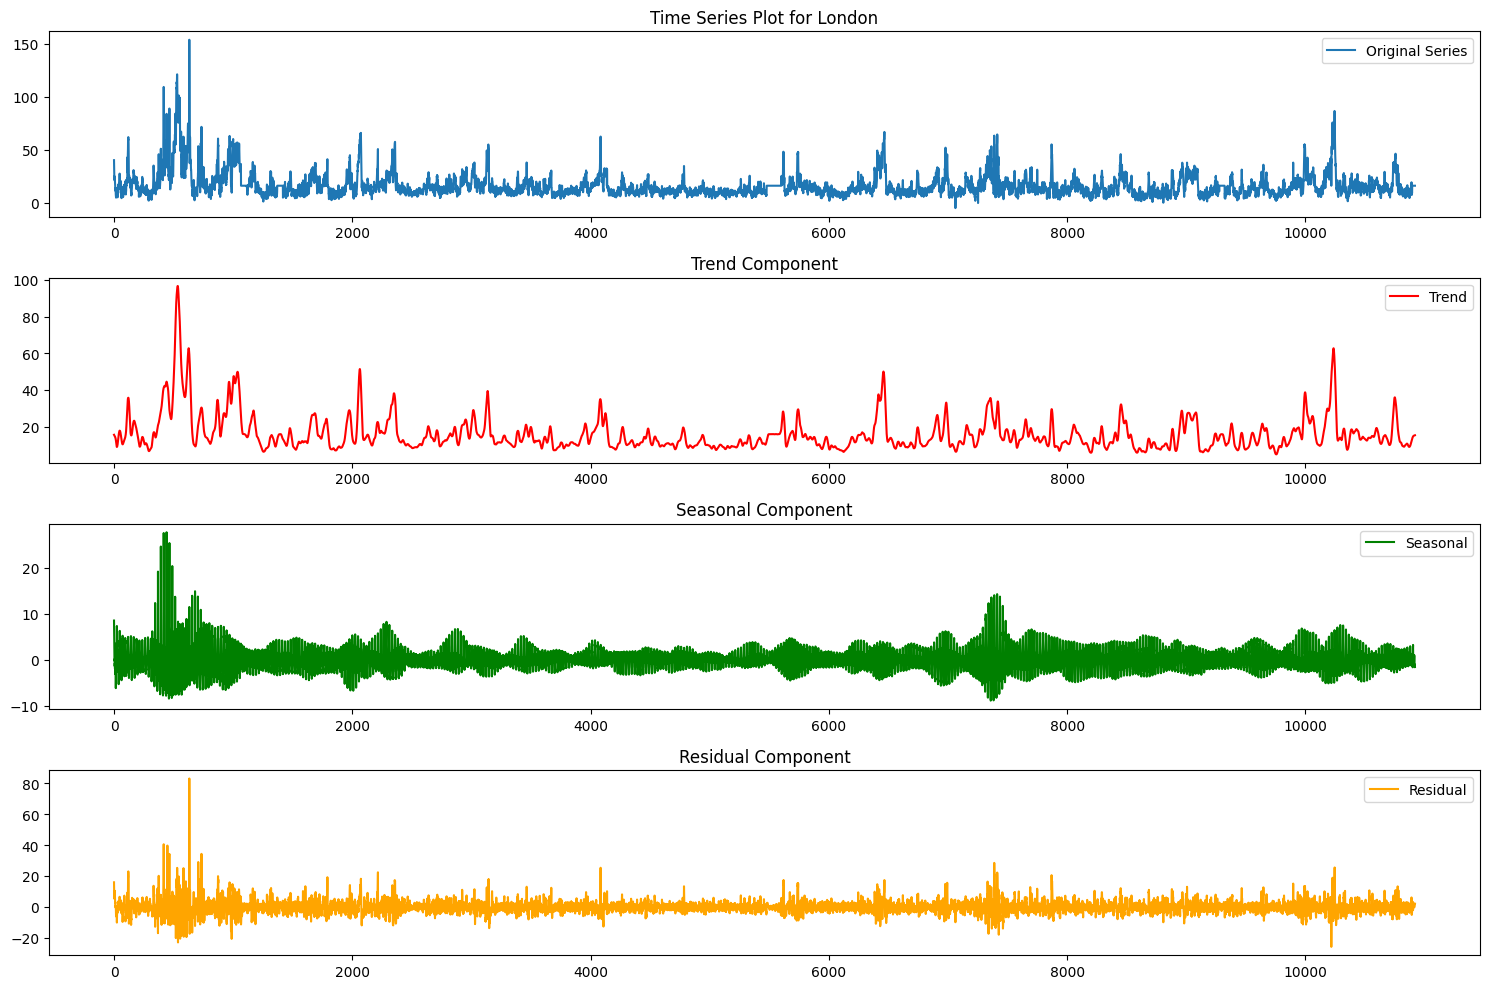

In [19]:
import numpy as np


London_series = loaded_data[loaded_data['city'] == 'London']['series_value'].values
London_series_numpy = np.asarray(London_series[0])
seasonal, trend, residual = decompose_time_series(London_series_numpy, city='London', period=24)


In [20]:
df = loaded_data[['start_timestamp','series_value']]
df.head(2)

,start_timestamp,series_value
0,2017-01-01 14:00:00,"[453.0, 417.0, 395.0, 420.0, 453.0, 429.0, 211..."
1,2017-01-01 14:00:00,"[467.0, 443.0, 467.0, 484.0, 520.0, 84.4725413..."


# **LSTM MODEL**

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Select the serie column
series_column = loaded_data['series_value']

# Convert all values in the "series_value" column to float
series_column_float = series_column.apply(lambda series: pd.to_numeric(series, errors='coerce'))

# Fill missing values in each series with the mean of the series
#series_column_filled = series_column_float.apply(lambda series: np.where(np.isnan(series), np.nanmean(series), series))

# Convert the series_column_filled to a list of lists
data_list = series_column_float.tolist()

# Normalize the data
scaler = MinMaxScaler()
data_normalized = [scaler.fit_transform(np.array(series).reshape(-1, 1)).flatten().tolist() for series in data_list]

# Pad sequences to handle varying lengths
data_padded = pad_sequences(data_normalized, dtype='float32', padding='post', truncating='post')

# Reshape the data into 3D format expected by LSTM (samples, time steps, features)
sequence_length = 4 # You can adjust this based on your preference
X, y = [], []

for i in range(len(data_padded) - sequence_length-1):
    X.append(data_padded[i:(i + sequence_length)])
    y.append(data_padded[i + sequence_length])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test, y_train, y_test = X[:split_index], X[split_index:], y[:split_index], y[split_index:]

In [22]:

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=200, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=100, activation='relu', return_sequences=True))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [23]:

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=200, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

# Normal Training
#history=model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=2, epochs=100)

trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)


Epoch 1/200
2/2 [==============================] - 7s 656ms/step - loss: 0.0309 - val_loss: 0.0879
Epoch 2/200
2/2 [==============================] - 0s 107ms/step - loss: 0.0438 - val_loss: 0.0554
Epoch 3/200
2/2 [==============================] - 0s 101ms/step - loss: 0.0377 - val_loss: 0.0371
Epoch 4/200
2/2 [==============================] - 0s 106ms/step - loss: 0.0182 - val_loss: 0.0134
Epoch 5/200
2/2 [==============================] - 0s 78ms/step - loss: 0.0126 - val_loss: 0.0148
Epoch 6/200
2/2 [==============================] - 0s 116ms/step - loss: 0.0119 - val_loss: 0.0134
Epoch 7/200
2/2 [==============================] - 0s 71ms/step - loss: 0.0109 - val_loss: 0.0227
Epoch 8/200
2/2 [==============================] - 0s 81ms/step - loss: 0.0116 - val_loss: 0.0150
Epoch 9/200
2/2 [==============================] - 0s 73ms/step - loss: 0.0109 - val_loss: 0.0150
Epoch 10/200
2/2 [==============================] - 0s 130ms/step - loss: 0.0105 - val_loss: 0.0173
Epoch 11/200


In [24]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 200)            8896800   
                                                                 
 lstm_1 (LSTM)               (None, 4, 100)            120400    
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 9047451 (34.51 MB)
Trainable params: 9047451 (34.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [25]:
# Inverse transform the predictions to original scale
predictions_original_scale = scaler.inverse_transform(trainPredict)
predictions_original_scale = scaler.inverse_transform(testPredict)

In [26]:
loss = model.evaluate(X_test, y_test)
print(f'Model Loss on Test Set: {loss}')
loss = model.evaluate(X_train, y_train)
print(f'Model Loss on Train Set: {loss}')

2/2 [==============================] - 0s 12ms/step - loss: 0.0178
Model Loss on Test Set: 0.01784977689385414
7/7 [==============================] - 0s 9ms/step - loss: 0.0113
Model Loss on Train Set: 0.011313737370073795
2/2 [==============================] - 0s 12ms/step - loss: 0.0178


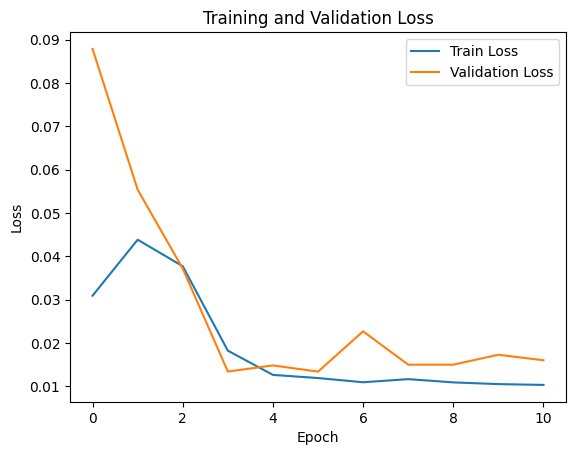

In [29]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [30]:
import math
from sklearn.metrics import mean_squared_error

# Inverse transform the predictions to original scale
trainPredict_original_scale = scaler.inverse_transform(trainPredict)
testPredict_original_scale = scaler.inverse_transform(testPredict)
column_index = 0

# Select the specific column from y_train NumPy array
y_train_column = y_train[:, column_index]

# Select the specific column from y_test NumPy array
y_test_column = y_test[:, column_index]

# Calculate RMSE
trainScore = np.sqrt(mean_squared_error(y_train_column, trainPredict_original_scale))
testScore = np.sqrt(mean_squared_error(y_test_column, testPredict_original_scale))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 18.96 RMSE
Test Score: 19.15 RMSE


<ipython-input-48-dab70e827277>:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('prediction_plot.png')  # Save the plot as an image file


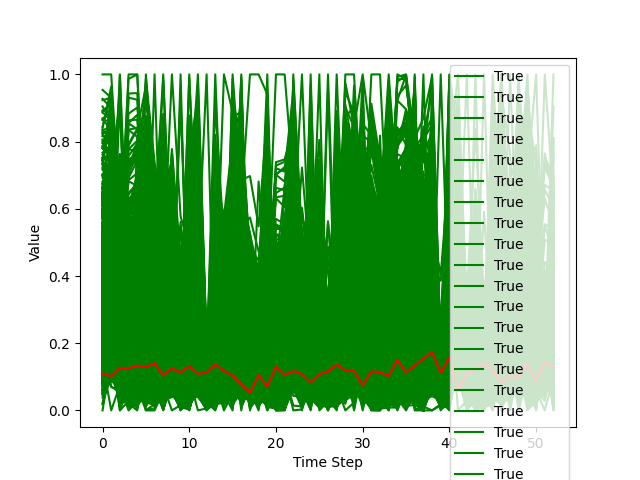

In [48]:

max_data_points = 1000
y_test_sliced = y_test[:max_data_points]
testPredict_sliced = testPredict[:max_data_points]

plt.plot(y_test_sliced, label="True", color='green')
plt.plot(testPredict_sliced, label="Prediction", color='red')
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.savefig('prediction_plot.png')  # Save the plot as an image file
plt.close()  # Close the plot to avoid displaying it directly in the notebook

# display the saved image
from IPython.display import Image
Image(filename='prediction_plot.png')


In [39]:
from sklearn.metrics import accuracy_score

# Assuming 'threshold' is the threshold used for classification
threshold = 0.5

# Convert predictions to binary values
predictions_binary = (testPredict_original_scale > threshold).astype(int)

# Convert true values to binary values
y_test_binary = (y_test_column > threshold).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, predictions_binary)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 3.77%


#**ARIMA | AUTO-ARIMA MODEL**

In [51]:
! pip install -q pmdarima

In [41]:
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Extract time series
selected_series = loaded_data[(loaded_data['series_name'] == 'T1') & (loaded_data['city'] == 'Beijing') & (loaded_data['air_quality_measurement'] == 'PM2.5')]
ts = selected_series['series_value'].iloc[0]
ts_values = [float(value) for value in ts]

# Divide data into training and test sets
train_size = int(len(ts_values) * 0.8)
train_data, test_data = ts_values[:train_size], ts_values[train_size:]

# Search for optimal parameters with pmdarima
auto_arima = pm.auto_arima(train_data, suppress_warnings=True, seasonal=False, stepwise=True)

#  Displays the optimal settings found
print("Paramètres optimaux :", auto_arima.order)

Paramètres optimaux : (0, 1, 0)


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Filter the dataset to get the specific time series
series_name  = 'T1'
city = 'Beijing'
measurement = 'PM2.5'

selected_series = loaded_data[(loaded_data['series_name'] == series_name) &
                     (loaded_data['city'] == city) &
                     (loaded_data['air_quality_measurement'] == measurement)]

# Select the appropriate column for the time series
ts = selected_series['series_value'].iloc[0]

# ConOpen the time series into a list of numeric values
ts_values = [float(value) for value in ts]
# Instantiate the ARIMA model
order = (0, 1, 0)
model = ARIMA(ts_values, order=order)

# Train the ARIMA model
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(ts_values), end=len(ts_values) + 10, typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [43]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10898
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -47011.773
Date:                Tue, 13 Feb 2024   AIC                          94025.545
Time:                        10:49:58   BIC                          94032.841
Sample:                             0   HQIC                         94028.004
                              - 10898                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       327.1502      0.680    481.216      0.000     325.818     328.483
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):           3127312.71
Prob(Q):                              0.34   Pr

In [44]:
import numpy as np
# Assuming actual_values and predictions are NumPy arrays or lists
actual_values = np.array(ts_values)
predictions = np.array(predictions)

# Check the lengths of both arrays
print("Length of actual_values:", len(actual_values))
print("Length of predictions:", len(predictions))

Length of actual_values: 10898
Length of predictions: 11


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Mean Squared Error (MSE): 7271.630365779479


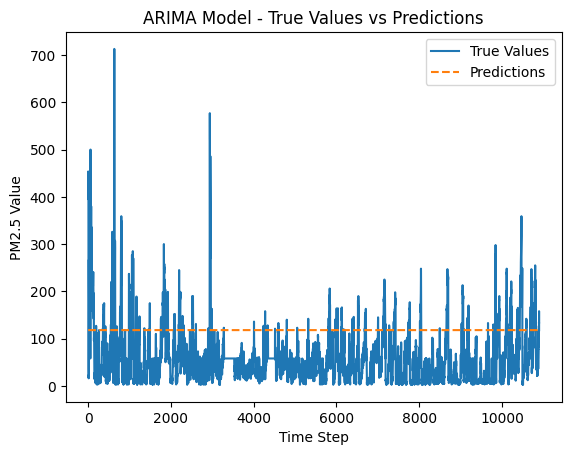

In [45]:
# Select the true values for the test set
true_values = loaded_data[(loaded_data['series_name'] == series_name) &
                          (loaded_data['city'] == city) &
                          (loaded_data['air_quality_measurement'] == measurement)]['series_value'].iloc[0]

# Convert the time series into a list of numeric values
true_values = [float(value) for value in true_values]

# Select predictions on the test set
predictions = model_fit.predict(start=len(ts_values), end=len(ts_values) + len(true_values) - 1, typ='levels')

# Check if both datasets have the same length
if len(true_values) == len(predictions):
    # Calculate Mean Square Error (MSE)
    mse = mean_squared_error(true_values, predictions)
    print(f'Mean Squared Error (MSE): {mse}')

    # Plot true values against predictions
    plt.plot(true_values, label='True Values')
    plt.plot(predictions, label='Predictions', linestyle='dashed')
    plt.title('ARIMA Model - True Values vs Predictions')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5 Value')
    plt.legend()
    plt.show()
else:
    print("Les ensembles de données n'ont pas la même longueur.")
